Activists have asserted that there is a strong gender bias in student evaluations of professors, with 
male professors enjoying a boost in rating from this bias. While this has been celebrated by ideologues, 
skeptics have pointed out that this research is of technically poor quality, either due to a low sample 
size – as small as n = 1 (Mitchell & Martin, 2018), failure to control for confounders such as teaching 
experience (Centra & Gaubatz, 2000) or obvious p-hacking (MacNell et al., 2015). We would like you to 
answer the question whether there is evidence of a pro-male gender bias in this dataset.  
Hint: A significance test is probably required.


The columns represent the following information, in order:
1. Average Rating (the arithmetic mean of all individual quality ratings of this professor)
2. Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)
3. Number of ratings (simply the total number of ratings these averages are based on)
4. Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)
5. The proportion of students that said they would take the class again
6. The number of ratings coming from online classes
7. Male gender (Boolean – 1: determined with high confidence that professor is male)
8. Female (Boolean – 1: determined with high confidence that professor is female)


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
seed = 10676128

Q7. Build a regression model predicting average rating from all numerical predictors (the ones in the rmpCapstoneNum.csv) file. Make sure to include the R2 and RMSE of this model. Which of these factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns

In [3]:
df_capstone = pd.read_csv('./rmpCapstoneNum.csv', header=None)
df_capstone.columns = ['Average Rating', 'Average Difficulty', 'Number of ratings', 'Received a pepper', 
                       'Proportion of students that said they would take the class again', 
                       'Number of ratings coming from online classes', 'Male Professor', 'Female Professor']

In [4]:
df_capstone=df_capstone[df_capstone['Number of ratings'] >= 10]

In [ ]:
df_capstone.isna().sum()

In [ ]:
df_capstone_na_dropped=df_capstone.dropna()

In [ ]:
df_capstone_na_dropped['Average Rating'].mean(),df_capstone_na_dropped['Average Rating'].median(),df_capstone_na_dropped['Average Rating'].std()

In [ ]:
df_only_na=df_capstone[df_capstone.isnull().any(axis=1)]

In [ ]:
df_only_na['Average Rating'].mean(),df_only_na['Average Rating'].median(),df_only_na['Average Rating'].std()

In [ ]:
sns.boxplot(df_only_na['Average Rating'])
plt.title('Distribution of Average Rating if Proportion column is missing')
plt.show()
sns.boxplot(df_capstone_na_dropped['Average Rating'])
plt.title('Distribution of Average Rating if Proportion column is present')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

sns.histplot(df_capstone_na_dropped['Average Rating'], bins=30, kde=True, color='blue', label='Average Rating if prop not missing', stat='density')
sns.histplot(df_only_na['Average Rating'], bins=30, kde=True, color='red', label='Average Rating if prop missing', stat='density')

plt.title('')
plt.xlabel('AverageProfessorRating')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
ks_stat, p_val = stats.ks_2samp(df_capstone_na_dropped['Average Rating'], df_only_na['Average Rating'])
mannwhitney_stat, mannwhitney_p_val = stats.mannwhitneyu(df_capstone_na_dropped['Average Rating'], df_only_na['Average Rating'])

print('KS Statistic: ', ks_stat)
print('P-value: ', p_val)
print('Mann Whitney U Statistic: ', mannwhitney_stat)
print('Mann Whitney U P-value: ', mannwhitney_p_val)

In [ ]:
df_capstone_na_dropped.describe()

In [ ]:
df_capstone_na_dropped['Proportion of online class ratings'] = df_capstone_na_dropped['Number of ratings coming from online classes'].div(df_capstone_na_dropped['Number of ratings'])

In [ ]:
df_capstone_na_dropped

In [ ]:
correlation_matrix = df_capstone_na_dropped.corr()

sns.heatmap(correlation_matrix,cmap = "RdBu_r", annot=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df_capstone_dropped_final=df_capstone_na_dropped

In [ ]:
df_capstone_dropped_final=df_capstone_dropped_final[(df_capstone_dropped_final['Male Professor']==1) & (df_capstone_dropped_final['Female Professor']==0) | (df_capstone_dropped_final['Male Professor']==0) & (df_capstone_dropped_final['Female Professor']==1)]

In [ ]:
df_capstone_dropped_final

In [ ]:
def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def normal_regression(X_train, y_train):
    return np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

def ridge_regression(X_train, y_train, alpha):
    n_features = X_train.shape[1]
    identity = np.eye(n_features)
    identity[0, 0] = 0  
    return np.linalg.inv(X_train.T @ X_train + alpha * identity) @ X_train.T @ y_train

def lasso_regression(X_train, y_train, alpha, max_iter=10000, tol=1e-6):
    m, n = X_train.shape
    beta = np.zeros(n)
    for _ in range(max_iter):
        beta_old = beta.copy()
        for j in range(n):
            residual = y_train - X_train @ beta + X_train[:, j] * beta[j]
            rho = X_train[:, j].T @ residual
            if j == 0:  
                beta[j] = rho / (X_train[:, j].T @ X_train[:, j])
            else:
                beta[j] = np.sign(rho) * max(0, abs(rho) - alpha) / (X_train[:, j].T @ X_train[:, j])
        if np.max(np.abs(beta - beta_old)) < tol:
            break
    return beta

In [ ]:
def getKFresults(X,y,alphas=np.array([0.00001,0.0001,0.001,0.01,0.1,1,2,5,10,20,100,1000,2000,100000])):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    results = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
        X_val_scaled = np.hstack((np.ones((X_val_scaled.shape[0], 1)), X_val_scaled))

        # Normal Regression
        beta_normal = normal_regression(X_train_scaled, y_train)
        y_pred_normal = X_val_scaled @ beta_normal
        rmse_normal = compute_rmse(y_val, y_pred_normal)
        r2_normal = compute_r2(y_val, y_pred_normal)
        
        # Ridge Regression
        for alpha in alphas:
            beta_ridge = ridge_regression(X_train_scaled, y_train, alpha)
            y_pred_ridge = X_val_scaled @ beta_ridge
            rmse_ridge = compute_rmse(y_val, y_pred_ridge)
            r2_ridge = compute_r2(y_val, y_pred_ridge)
            results.append(('Ridge', beta_ridge,alpha, rmse_ridge, r2_ridge))
        
        # Lasso Regression
        for alpha in alphas:
            beta_lasso = lasso_regression(X_train_scaled, y_train, alpha)
            y_pred_lasso = X_val_scaled @ beta_lasso
            rmse_lasso = compute_rmse(y_val, y_pred_lasso)
            r2_lasso = compute_r2(y_val, y_pred_lasso)
            results.append(('Lasso', beta_lasso, alpha, rmse_lasso, r2_lasso))
        
        results.append(('Normal',beta_normal, None, rmse_normal, r2_normal))
    return results

In [ ]:
def getfinalresults(X_train,y_train,X_test,y_test,alphas=np.array([0.00001,0.0001,0.001,0.01,0.1,1,2,5,10,20,100,1000,2000,100000])):
    results = []

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
    X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

    # Normal Regression
    beta_normal = normal_regression(X_train_scaled, y_train)
    y_pred_normal = X_test_scaled @ beta_normal
    rmse_normal = compute_rmse(y_test, y_pred_normal)
    r2_normal = compute_r2(y_test, y_pred_normal)

    residuals = y_test - y_pred_normal

    ## Residual plot
    plt.figure(figsize=(10, 6))
    # Grab standardized residuals for plot
    std_residuals = (residuals - residuals.mean()) / residuals.std()
    plt.scatter(y_pred_normal, std_residuals, color='blue')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Horizontal line at y=0

    # Labels and title
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values (y_hat)")
    plt.ylabel("Standardized Residuals")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ## Pretty even spread in the residuals (homoscedasticity? - check)
    fig, ax = plt.subplots(figsize=(10,6))

    # See histogram of residuals to check for normality
    ax.hist(residuals, bins=15, color='green', edgecolor='black', density=True) # Add density
    ax.set_title("Histogram of Residuals")
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Density")
    
    # Ridge Regression
    for alpha in alphas:
        beta_ridge = ridge_regression(X_train_scaled, y_train, alpha)
        y_pred_ridge = X_test_scaled @ beta_ridge
        rmse_ridge = compute_rmse(y_test, y_pred_ridge)
        r2_ridge = compute_r2(y_test, y_pred_ridge)
        results.append(('Ridge', alpha, rmse_ridge, r2_ridge))
    
    # Lasso Regression
    for alpha in alphas:
        beta_lasso = lasso_regression(X_train_scaled, y_train, alpha)
        y_pred_lasso = X_test_scaled @ beta_lasso
        rmse_lasso = compute_rmse(y_test, y_pred_lasso)
        r2_lasso = compute_r2(y_test, y_pred_lasso)
        results.append(('Lasso', alpha, rmse_lasso, r2_lasso))
        residuals = y_test - y_pred_lasso

        ## Residual plot
        plt.figure(figsize=(10, 6))
        # Grab standardized residuals for plot
        std_residuals = (residuals - residuals.mean()) / residuals.std()
        plt.scatter(y_pred_lasso, std_residuals, color='blue')
        plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Horizontal line at y=0

        # Labels and title
        plt.title(f"Residual Plot lasso alpha= {alpha}")
        plt.xlabel("Predicted Values (y_hat)")
        plt.ylabel("Standardized Residuals")

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        ## Pretty even spread in the residuals (homoscedasticity? - check)
        fig, ax = plt.subplots(figsize=(10,6))

        # See histogram of residuals to check for normality
        ax.hist(residuals, bins=15, color='green', edgecolor='black', density=True) # Add density
        ax.set_title("Histogram of Residuals")
        ax.set_xlabel("Residuals")
        ax.set_ylabel("Density")
    
    results.append(('Normal', None, rmse_normal, r2_normal))
    return results

In [ ]:
def getbetas(X_train,y_train,X_test,y_test):
    results=[]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
    X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

    # Normal Regression
    beta_normal = normal_regression(X_train_scaled, y_train)
    y_pred_normal = X_test_scaled @ beta_normal
    rmse_normal = compute_rmse(y_test, y_pred_normal)
    r2_normal = compute_r2(y_test, y_pred_normal)
    results.append(('Normal',beta_normal, rmse_normal, r2_normal))
    return beta_normal,rmse_normal,r2_normal



In [ ]:
def getbetaslasso(X_train,y_train,X_test,y_test,alpha=10):
    results=[]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
    X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

    # Normal Regression
    beta_lasso = lasso_regression(X_train_scaled, y_train, alpha)
    y_pred_lasso = X_test_scaled @ beta_lasso
    rmse_lasso = compute_rmse(y_test, y_pred_lasso)
    r2_lasso = compute_r2(y_test, y_pred_lasso)
    results.append(('Lasso', beta_lasso, rmse_lasso, r2_lasso))
    return beta_lasso,rmse_lasso,r2_lasso

In [ ]:
def getbetasridge(X_train,y_train,X_test,y_test,alpha=10):
    results=[]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
    X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

    # Normal Regression
    beta_ridge = ridge_regression(X_train_scaled, y_train, alpha)
    y_pred_ridge = X_test_scaled @ beta_ridge
    rmse_ridge = compute_rmse(y_test, y_pred_ridge)
    r2_ridge = compute_r2(y_test, y_pred_ridge)
    results.append(('ridge', beta_ridge, rmse_ridge, r2_ridge))
    return beta_ridge,rmse_ridge,r2_ridge

In [ ]:
def plot_results(results_df,alphas=np.array([0.00001,0.0001,0.001,0.01,0.1,1,2,5,10,20,100,1000,2000,100000])):
    ridge_results = results_df[results_df['Model'] == 'Ridge'].drop(columns=['Model']).groupby('Alpha').mean()
    lasso_results = results_df[results_df['Model'] == 'Lasso'].drop(columns=['Model']).groupby('Alpha').mean()
    normal_results = results_df[results_df['Model']=='Normal'].drop(columns=['Model','Alpha']).mean()
    
    plt.figure(figsize=(10, 6))
    plt.xscale("log")

    plt.plot(alphas, ridge_results['RMSE'], marker='o', label='Ridge Regression RMSE')
    plt.plot(alphas, lasso_results['RMSE'], marker='s', label='Lasso Regression RMSE')
    
    plt.axhline(y=normal_results['RMSE'], color='r', linestyle='--', label='Normal Regression RMSE')

    plt.title('RMSE Comparison Across Models')
    plt.xlabel('Alpha (Regularization Parameter)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.xscale("log")

    plt.plot(alphas, ridge_results['R2'], marker='o', label='Ridge Regression R2')
    plt.plot(alphas, lasso_results['R2'], marker='s', label='Lasso Regression R2')

    plt.axhline(y=normal_results['R2'], color='r', linestyle='--', label='Normal Regression R2')

    plt.title('R2 Comparison Across Models')
    plt.xlabel('Alpha (Regularization Parameter)')
    plt.ylabel('R2')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def plot_betas(betas,feature_names=0,mytype='Normal',alpha=10):
    # Plot the coefficients (betas) for all models
    plt.figure(figsize=(24, 6))
    # Ridge Regression Coefficients (for best alpha)
    if(feature_names==0):
        feature_names=range(len(betas))
    #plt.xticks(range(len(betas)))
    plt.bar([str(i) for i in feature_names], betas)
    if mytype=='Normal':
        plt.title(f'Coefficients Regression)')
    if mytype=='Ridge':
        plt.title(f'Coefficients Ridge (alpha={alpha})')
    if mytype=='Lasso':
        plt.title(f'Coefficients Ridge (alpha={alpha})')
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')

    plt.tight_layout()
    plt.show()

In [ ]:
dependent_var='Average Rating'
for var in df_capstone_dropped_final.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df_capstone_dropped_final[var], y=df_capstone_dropped_final[dependent_var])
    plt.title(f'Scatterplot of {dependent_var} vs {var}')
    plt.xlabel(var)
    plt.ylabel(dependent_var)
    plt.grid(True)
    plt.show()

In [ ]:
X = np.array([
    df_capstone_dropped_final['Average Difficulty'],
    df_capstone_dropped_final['Number of ratings'],
    df_capstone_dropped_final['Received a pepper'],
    df_capstone_dropped_final['Female Professor'],
    df_capstone_dropped_final['Proportion of online class ratings'],
    df_capstone_dropped_final['Proportion of students that said they would take the class again']

]).T

y = np.array(df_capstone_dropped_final['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X,y,alphas=np.array([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 100, 1000,1500, 100000]))

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')

plot_results(results_df,alphas=np.array([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 100, 1000,1500, 100000]))

In [ ]:
[(i,j) for i,j in zip(results_df2[results_df2['Model']=='Lasso']['Betas'][0:14],results_df2[results_df2['Model']=='Lasso']['RMSE'][0:14])]

In [ ]:
results_df[results_df['Model'] == 'Ridge'].drop(columns=['Model']).groupby('Alpha').mean()

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test,alphas=np.array([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 100, 1000,2000, 100000]))
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df,alphas=np.array([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 100, 1000,2000, 100000]))

In [ ]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetas(X_train,y_train,X_test,y_test)[0][1:],[i.name for i in [
    df_capstone_dropped_final['Average Difficulty'],
    df_capstone_dropped_final['Number of ratings'],
    df_capstone_dropped_final['Received a pepper'],
    df_capstone_dropped_final['Female Professor'],
    df_capstone_dropped_final['Proportion of online class ratings'],
    df_capstone_dropped_final['Proportion of students that said they would take the class again']
]])

In [ ]:
X = np.array([
    df_capstone_dropped_final['Proportion of students that said they would take the class again'],
    df_capstone_dropped_final['Average Difficulty'],
    df_capstone_dropped_final['Received a pepper']
]).T

y = np.array(df_capstone_dropped_final['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0] 
indices = np.argsort(mybetas)[::-1] 
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetas(X_train,y_train,X_test,y_test)[0][1:],[i.name for i in [
    df_capstone_dropped_final['Proportion of students that said they would take the class again'],
    df_capstone_dropped_final['Average Difficulty'],
    df_capstone_dropped_final['Received a pepper']
]])

In [ ]:
[i for i in results_df2[results_df2['Model']=='Lasso']['Betas'][0:14]]

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [ ]:
X = np.array([
    df_capstone_dropped_final['Proportion of students that said they would take the class again']
]).T

y = np.array(df_capstone_dropped_final['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model', 'Betas','Alpha', 'RMSE', 'R2'])
results_df=results_df2.drop(columns=['Betas'])
plot_results(results_df)

In [ ]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0] 
indices = np.argsort(mybetas)[::-1] 
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetas(X_train,y_train,X_test,y_test)[0][1:])

In [ ]:
[(i,j) for i,j in zip(results_df2[results_df2['Model']=='Lasso']['Betas'][0:14],results_df2[results_df2['Model']=='Lasso']['RMSE'][0:14])]

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [5]:
tagsdf=pd.read_csv('./rmpCapstoneTags.csv', header=None)

In [ ]:
Q8df=df_capstone[['Average Rating','Number of ratings']].join(tagsdf, how='inner')


In [ ]:
Q8df.dropna(inplace=True)

In [ ]:
Q8df

In [ ]:
for i in Q8df.columns[2:]:
    Q8df[i] = Q8df[i].div(Q8df['Number of ratings'])

In [ ]:
Q8df

In [ ]:
Q8dfgreater10=Q8df[Q8df['Number of ratings'] >= 10]

In [ ]:
Q8dfgreater10

In [ ]:
corrgreater40=Q8dfgreater10.corr()[Q8dfgreater10.corr()>0.42]
[i for i in list(corrgreater40[corrgreater40.notnull()].stack().index) if i[0]!=i[1]]

In [ ]:
correlation_matrix = Q8dfgreater10.drop(columns=['Number of ratings','Average Rating']).corr()
plt.figure(figsize = (40,40))
sns.heatmap(correlation_matrix,cmap = "RdBu_r", annot=True)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
dependent_var='Average Rating'
for var in Q8dfgreater10.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=Q8dfgreater10[var], y=Q8dfgreater10[dependent_var])
    plt.title(f'Scatterplot of {dependent_var} vs {var}')
    plt.xlabel(var)
    plt.ylabel(dependent_var)
    plt.grid(True)
    plt.show()

In [ ]:
Q8dfgreater10.corr()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def plot_forward_selection_results(results_df):
    plt.figure(figsize=(12, 6))

    # RMSE plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(results_df) + 1), results_df['RMSE'], marker='o', label='RMSE')
    plt.title('Forward Feature Selection: RMSE')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('RMSE')
    plt.grid(True)

    # R² plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(results_df) + 1), results_df['R2'], marker='o', label='R²')
    plt.title('Forward Feature Selection: R²')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('R²')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def forward_feature_selection_kfold(X, y, k=5, max_features=None):
    """
    Perform forward feature selection using k-fold cross-validation.

    Parameters:
    - X: DataFrame of features
    - y: Series of target variable
    - k: Number of folds for cross-validation
    - max_features: Max number of features to select. If None, select all.

    Returns:
    - selected_features: List of selected features
    - results: List of results for each feature set (including average RMSE, R², etc.)
    """
    remaining_features = list(X.columns)
    selected_features = []
    results = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    while remaining_features:
        best_rmse = float('inf')
        best_feature = None
        best_betas = None
        best_alpha = None
        
        for feature in remaining_features:
            # Create a subset of the data with the current selected features + one more
            X_temp = X[selected_features + [feature]]
            
            rmse_list = []
            r2_list = []
            
            for train_idx, val_idx in kf.split(X_temp):
                X_train_fold, X_val_fold = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
                y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                
                # Train a model
                model = LinearRegression()
                model.fit(X_train_fold, y_train_fold)
                
                # Make predictions and evaluate the model
                y_pred_fold = model.predict(X_val_fold)
                rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
                r2_fold = r2_score(y_val_fold, y_pred_fold)
                
                rmse_list.append(rmse_fold)
                r2_list.append(r2_fold)
            
            # Calculate average RMSE and R² across folds
            avg_rmse = np.mean(rmse_list)
            avg_r2 = np.mean(r2_list)
            
            # Store the best feature and corresponding metrics
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_feature = feature
                best_betas = model.coef_
                best_alpha = model.intercept_
        
        # Update the list of selected features
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        
        # Append the result for the current model
        results.append([selected_features.copy(), best_betas, best_alpha, best_rmse, avg_r2])
        
        # Stop if we've reached the maximum number of features (if specified)
        if max_features is not None and len(selected_features) >= max_features:
            break

    return selected_features, results
X = Q8dfgreater10.drop(columns=['Average Rating','Number of ratings'])  # assuming all columns except 'Average Rating' are features
y = Q8dfgreater10['Average Rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Perform forward feature selection with k-fold cross-validation
selected_features_kfold, forward_results_kfold = forward_feature_selection_kfold(X_train, y_train, k=5)

# Convert results to a DataFrame
forward_results_kfold_df = pd.DataFrame(forward_results_kfold, columns=['Selected Features', 'Betas', 'Alpha', 'RMSE', 'R2'])

# Optionally, remove the 'Betas' column for cleaner display
forward_results_kfold_df_cleaned = forward_results_kfold_df.drop(columns='Betas')

# Plot the results
plot_forward_selection_results(forward_results_kfold_df_cleaned)

# Evaluate the final model on the test set
best_selected_features_kfold = forward_results_kfold_df.iloc[-1]['Selected Features']
X_train_best_kfold = X_train[best_selected_features_kfold]
X_test_best_kfold = X_test[best_selected_features_kfold]

final_model_kfold = LinearRegression()
final_model_kfold.fit(X_train_best_kfold, y_train)
y_pred_test_kfold = final_model_kfold.predict(X_test_best_kfold)

final_rmse_kfold = np.sqrt(mean_squared_error(y_test, y_pred_test_kfold))
final_r2_kfold = r2_score(y_test, y_pred_test_kfold)

print(f"Final Model with K-Fold RMSE: {final_rmse_kfold}")
print(f"Final Model with K-Fold R²: {final_r2_kfold}")


In [ ]:
forward_results_kfold_df

In [ ]:
X = np.array([
    Q8dfgreater10[0],
    Q8dfgreater10[1],
    Q8dfgreater10[2],
    Q8dfgreater10[3],
    Q8dfgreater10[4],
    Q8dfgreater10[5],
    Q8dfgreater10[6],
    Q8dfgreater10[7],
    Q8dfgreater10[8],
    Q8dfgreater10[9],
    Q8dfgreater10[10],
    Q8dfgreater10[11],
    Q8dfgreater10[12],
    Q8dfgreater10[13],
    Q8dfgreater10[14],
    Q8dfgreater10[15],
    Q8dfgreater10[16],
    Q8dfgreater10[17],
    Q8dfgreater10[18],
    Q8dfgreater10[19],
]).T

y = np.array(Q8dfgreater10['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0] 
indices = np.argsort(mybetas)[::-1] 
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetas(X_train,y_train,X_test,y_test)[0][1:],[i.name for i in [
    Q8dfgreater10[0],
    Q8dfgreater10[1],
    Q8dfgreater10[2],
    Q8dfgreater10[3],
    Q8dfgreater10[4],
    Q8dfgreater10[5],
    Q8dfgreater10[6],
    Q8dfgreater10[7],
    Q8dfgreater10[8],
    Q8dfgreater10[9],
    Q8dfgreater10[10],
    Q8dfgreater10[11],
    Q8dfgreater10[12],
    Q8dfgreater10[13],
    Q8dfgreater10[14],
    Q8dfgreater10[15],
    Q8dfgreater10[16],
    Q8dfgreater10[17],
    Q8dfgreater10[18],
    Q8dfgreater10[19],
]])

In [ ]:
[(i,j) for i,j in zip(results_df2[results_df2['Model']=='Lasso']['Betas'][0:14],results_df2[results_df2['Model']=='Lasso']['RMSE'][0:14])]

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [ ]:
X = np.array([
    Q8dfgreater10[2]
]).T
X_sqrt = np.sqrt(X)   # Square root of the column
X_square = np.square(X)  # Square of the column
X_cube = np.power(X, 3)  # Cube of the column

X_extended = np.hstack((X, X_sqrt, X_square, X_cube))
X=X_extended
y = np.array(Q8dfgreater10['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
X = np.array([
    Q8dfgreater10[0]
]).T

y = np.array(Q8dfgreater10['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
results_df[results_df['Model']=='Normal'].drop(columns=['Model','Alpha']).mean()


In [ ]:
getbetas(X_train,y_train,X_test,y_test)

In [ ]:
X = np.array([
    Q8dfgreater10[0],
    Q8dfgreater10[1],
    Q8dfgreater10[2],
    Q8dfgreater10[15],
    Q8dfgreater10[16],
    Q8dfgreater10[12],
]).T
y = np.array(Q8dfgreater10['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
[(i,j) for i,j in zip(results_df2[results_df2['Model']=='Lasso']['Betas'][0:14],results_df2[results_df2['Model']=='Lasso']['RMSE'][0:14])]

In [ ]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices) 
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetas(X_train,y_train,X_test,y_test)[0][1:],[i.name for i in [
    Q8dfgreater10[0],
    Q8dfgreater10[1],
    Q8dfgreater10[2],
    Q8dfgreater10[15],
    Q8dfgreater10[16],
    Q8dfgreater10[12],
]])

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [ ]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0] 
indices = np.argsort(mybetas)[::-1] 
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetas(X_train,y_train,X_test,y_test)[0][1:])

#### 9. Build a regression model predicting average difficulty from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2and RMSE of this model. Which of these tags is most strongly predictive of average difficulty? Hint: Make sure to address collinearity concerns

In [ ]:
Q9df=df_capstone[['Average Difficulty','Number of ratings']].join(tagsdf, how='inner')

In [ ]:
Q9df.head(2)

In [ ]:
Q9df.dropna(inplace=True)

In [ ]:
Q9df.head(2)

In [ ]:
for i in Q9df.columns[2:]:
    Q9df[i] = Q9df[i].div(Q9df['Number of ratings'])

In [ ]:
Q9df.head(2)

In [ ]:
Q9dfgreater10=Q9df[Q9df['Number of ratings'] >= 10]

In [ ]:
Q9dfgreater10.head(2)

In [ ]:
Q9dfgreater10.corr()

In [ ]:
corrgreater40=Q9dfgreater10.corr()[Q9dfgreater10.corr()>0.30]
[i for i in list(corrgreater40[corrgreater40.notnull()].stack().index) if i[0]!=i[1]]

In [ ]:
dependent_var='Average Difficulty'
for var in Q9dfgreater10.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=Q9dfgreater10[var], y=Q9dfgreater10[dependent_var])
    plt.title(f'Scatterplot of {dependent_var} vs {var}')
    plt.xlabel(var)
    plt.ylabel(dependent_var)
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = Q9dfgreater10.drop(columns=['Average Difficulty','Number of ratings'])  # assuming all columns except 'Average Rating' are features
y = Q9dfgreater10['Average Difficulty']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def plot_forward_selection_results(results_df):
    plt.figure(figsize=(12, 6))

    # RMSE plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(results_df) + 1), results_df['RMSE'], marker='o', label='RMSE')
    plt.title('Forward Feature Selection: RMSE')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('RMSE')
    plt.grid(True)

    # R² plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(results_df) + 1), results_df['R2'], marker='o', label='R²')
    plt.title('Forward Feature Selection: R²')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('R²')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def forward_feature_selection_kfold(X, y, k=5, max_features=None):
    """
    Perform forward feature selection using k-fold cross-validation.

    Parameters:
    - X: DataFrame of features
    - y: Series of target variable
    - k: Number of folds for cross-validation
    - max_features: Max number of features to select. If None, select all.

    Returns:
    - selected_features: List of selected features
    - results: List of results for each feature set (including average RMSE, R², etc.)
    """
    remaining_features = list(X.columns)
    selected_features = []
    results = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    while remaining_features:
        best_rmse = float('inf')
        best_feature = None
        best_betas = None
        best_alpha = None
        
        for feature in remaining_features:
            # Create a subset of the data with the current selected features + one more
            X_temp = X[selected_features + [feature]]
            
            rmse_list = []
            r2_list = []
            
            for train_idx, val_idx in kf.split(X_temp):
                X_train_fold, X_val_fold = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
                y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                
                # Train a model
                model = LinearRegression()
                model.fit(X_train_fold, y_train_fold)
                
                # Make predictions and evaluate the model
                y_pred_fold = model.predict(X_val_fold)
                rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
                r2_fold = r2_score(y_val_fold, y_pred_fold)
                
                rmse_list.append(rmse_fold)
                r2_list.append(r2_fold)
            
            # Calculate average RMSE and R² across folds
            avg_rmse = np.mean(rmse_list)
            avg_r2 = np.mean(r2_list)
            
            # Store the best feature and corresponding metrics
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_feature = feature
                best_betas = model.coef_
                best_alpha = model.intercept_
        
        # Update the list of selected features
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        
        # Append the result for the current model
        results.append([selected_features.copy(), best_betas, best_alpha, best_rmse, avg_r2])
        
        # Stop if we've reached the maximum number of features (if specified)
        if max_features is not None and len(selected_features) >= max_features:
            break

    return selected_features, results

# Perform forward feature selection with k-fold cross-validation
selected_features_kfold, forward_results_kfold = forward_feature_selection_kfold(X_train, y_train, k=5)

# Convert results to a DataFrame
forward_results_kfold_df = pd.DataFrame(forward_results_kfold, columns=['Selected Features', 'Betas', 'Alpha', 'RMSE', 'R2'])

# Optionally, remove the 'Betas' column for cleaner display
forward_results_kfold_df_cleaned = forward_results_kfold_df.drop(columns='Betas')

# Plot the results
plot_forward_selection_results(forward_results_kfold_df_cleaned)

# Evaluate the final model on the test set
best_selected_features_kfold = forward_results_kfold_df.iloc[-1]['Selected Features']
X_train_best_kfold = X_train[best_selected_features_kfold]
X_test_best_kfold = X_test[best_selected_features_kfold]

final_model_kfold = LinearRegression()
final_model_kfold.fit(X_train_best_kfold, y_train)
y_pred_test_kfold = final_model_kfold.predict(X_test_best_kfold)

final_rmse_kfold = np.sqrt(mean_squared_error(y_test, y_pred_test_kfold))
final_r2_kfold = r2_score(y_test, y_pred_test_kfold)

print(f"Final Model with K-Fold RMSE: {final_rmse_kfold}")
print(f"Final Model with K-Fold R²: {final_r2_kfold}")


In [ ]:
forward_results_kfold_df

In [ ]:
X = np.array([
    Q9dfgreater10[0],
    Q9dfgreater10[1],
    Q9dfgreater10[2],
    Q9dfgreater10[3],
    Q9dfgreater10[4],
    Q9dfgreater10[5],
    Q9dfgreater10[6],
    Q9dfgreater10[7],
    Q9dfgreater10[8],
    Q9dfgreater10[9],
    Q9dfgreater10[10],
    Q9dfgreater10[11],
    Q9dfgreater10[12],
    Q9dfgreater10[13],
    Q9dfgreater10[14],
    Q9dfgreater10[15],
    Q9dfgreater10[16],
    Q9dfgreater10[17],
    Q9dfgreater10[18],
    Q9dfgreater10[19],
]).T

y = np.array(Q9dfgreater10['Average Difficulty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
mybetas=getbetaslasso(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices) 
print(mybetas[indices]) 
print(getbetaslasso(X_train,y_train,X_test,y_test,alpha=1000))
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetaslasso(X_train,y_train,X_test,y_test,alpha=1000)[0][1:],[i.name for i in [
    Q9dfgreater10[0],
    Q9dfgreater10[1],
    Q9dfgreater10[2],
    Q9dfgreater10[3],
    Q9dfgreater10[4],
    Q9dfgreater10[5],
    Q9dfgreater10[6],
    Q9dfgreater10[7],
    Q9dfgreater10[8],
    Q9dfgreater10[9],
    Q9dfgreater10[10],
    Q9dfgreater10[11],
    Q9dfgreater10[12],
    Q9dfgreater10[13],
    Q9dfgreater10[14],
    Q9dfgreater10[15],
    Q9dfgreater10[16],
    Q9dfgreater10[17],
    Q9dfgreater10[18],
    Q9dfgreater10[19],
]],'Lasso')


In [ ]:
[(i,j) for i,j in zip(results_df2[results_df2['Model']=='Lasso']['Betas'][0:14],results_df2[results_df2['Model']=='Lasso']['RMSE'][0:14])]

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [ ]:
X = np.array([
    Q9dfgreater10[0]
]).T
X_sqrt = np.sqrt(X)   # Square root of the column
X_square = np.square(X)  # Square of the column
X_cube = np.power(X, 3)  # Cube of the column

X_extended = np.hstack((X, X_sqrt, X_square, X_cube))
X=X_extended
y = np.array(Q9dfgreater10['Average Difficulty'])
#y = np.sqrt(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [ ]:
[(i,j) for i,j in zip(results_df2[results_df2['Model']=='Lasso']['Betas'][0:14],results_df2[results_df2['Model']=='Lasso']['RMSE'][0:14])]

In [ ]:
X = np.array([
    Q9dfgreater10[0],
    Q9dfgreater10[13],
    Q9dfgreater10[6],
    Q9dfgreater10[3],
    Q9dfgreater10[9]
]).T

X_sqrt = np.sqrt(X)   # Square root of the column

X_extended = np.hstack((X, X_sqrt))
X=X_extended
y = np.array(Q9dfgreater10['Average Difficulty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [ ]:
mybetas=getbetaslasso(X_train,y_train,X_test,y_test,alpha=1000)[0]
indices = np.argsort(mybetas)[::-1]
print(indices) 
print(getbetaslasso(X_train,y_train,X_test,y_test,alpha=100))
plot_betas(getbetaslasso(X_train,y_train,X_test,y_test,alpha=100)[0][1:])

In [ ]:
X = np.array([
    Q9dfgreater10[0],
    Q9dfgreater10[13],
    Q9dfgreater10[6],
    Q9dfgreater10[3],
    Q9dfgreater10[9]
]).T

y = np.array(Q9dfgreater10['Average Difficulty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [ ]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices) 
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetas(X_train,y_train,X_test,y_test)[0][1:],[i.name for i in [
    Q9dfgreater10[0],
    Q9dfgreater10[13],
    Q9dfgreater10[6],
    Q9dfgreater10[3],
    Q9dfgreater10[9]
]])

In [ ]:
Q9dfgreater10.corr()

In [ ]:
X = np.array([
    Q9dfgreater10[0],
]).T

y = np.array(Q9dfgreater10['Average Difficulty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df2 = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2'])
results_df = pd.DataFrame(results, columns=['Model','Betas','Alpha', 'RMSE', 'R2']).drop(columns='Betas')
plot_results(results_df)

In [ ]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices) 
print(getbetas(X_train,y_train,X_test,y_test))
plot_betas(getbetas(X_train,y_train,X_test,y_test)[0][1:])

In [ ]:
results=getfinalresults(X_train,y_train,X_test,y_test)
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])
plot_results(results_df)

In [12]:
Q10df=df_capstone.join(tagsdf, how='inner')

In [42]:
Q10df.columns

Index([                                                  'Average Rating',
                                                     'Average Difficulty',
                                                      'Number of ratings',
                                                      'Received a pepper',
       'Proportion of students that said they would take the class again',
                           'Number of ratings coming from online classes',
                                                         'Male Professor',
                                                       'Female Professor',
                                                                        0,
                                                                        1,
                                                                        2,
                                                                        3,
                                                                        4,
                         

In [13]:
Q10df.dropna(inplace=True)

In [14]:
for i in Q10df.columns[8:]:
    Q10df[i] = Q10df[i].div(Q10df['Number of ratings'])

In [16]:
Q10df=Q10df[(Q10df['Male Professor']==1) & (Q10df['Female Professor']==0) | (Q10df['Male Professor']==0) & (Q10df['Female Professor']==1)]

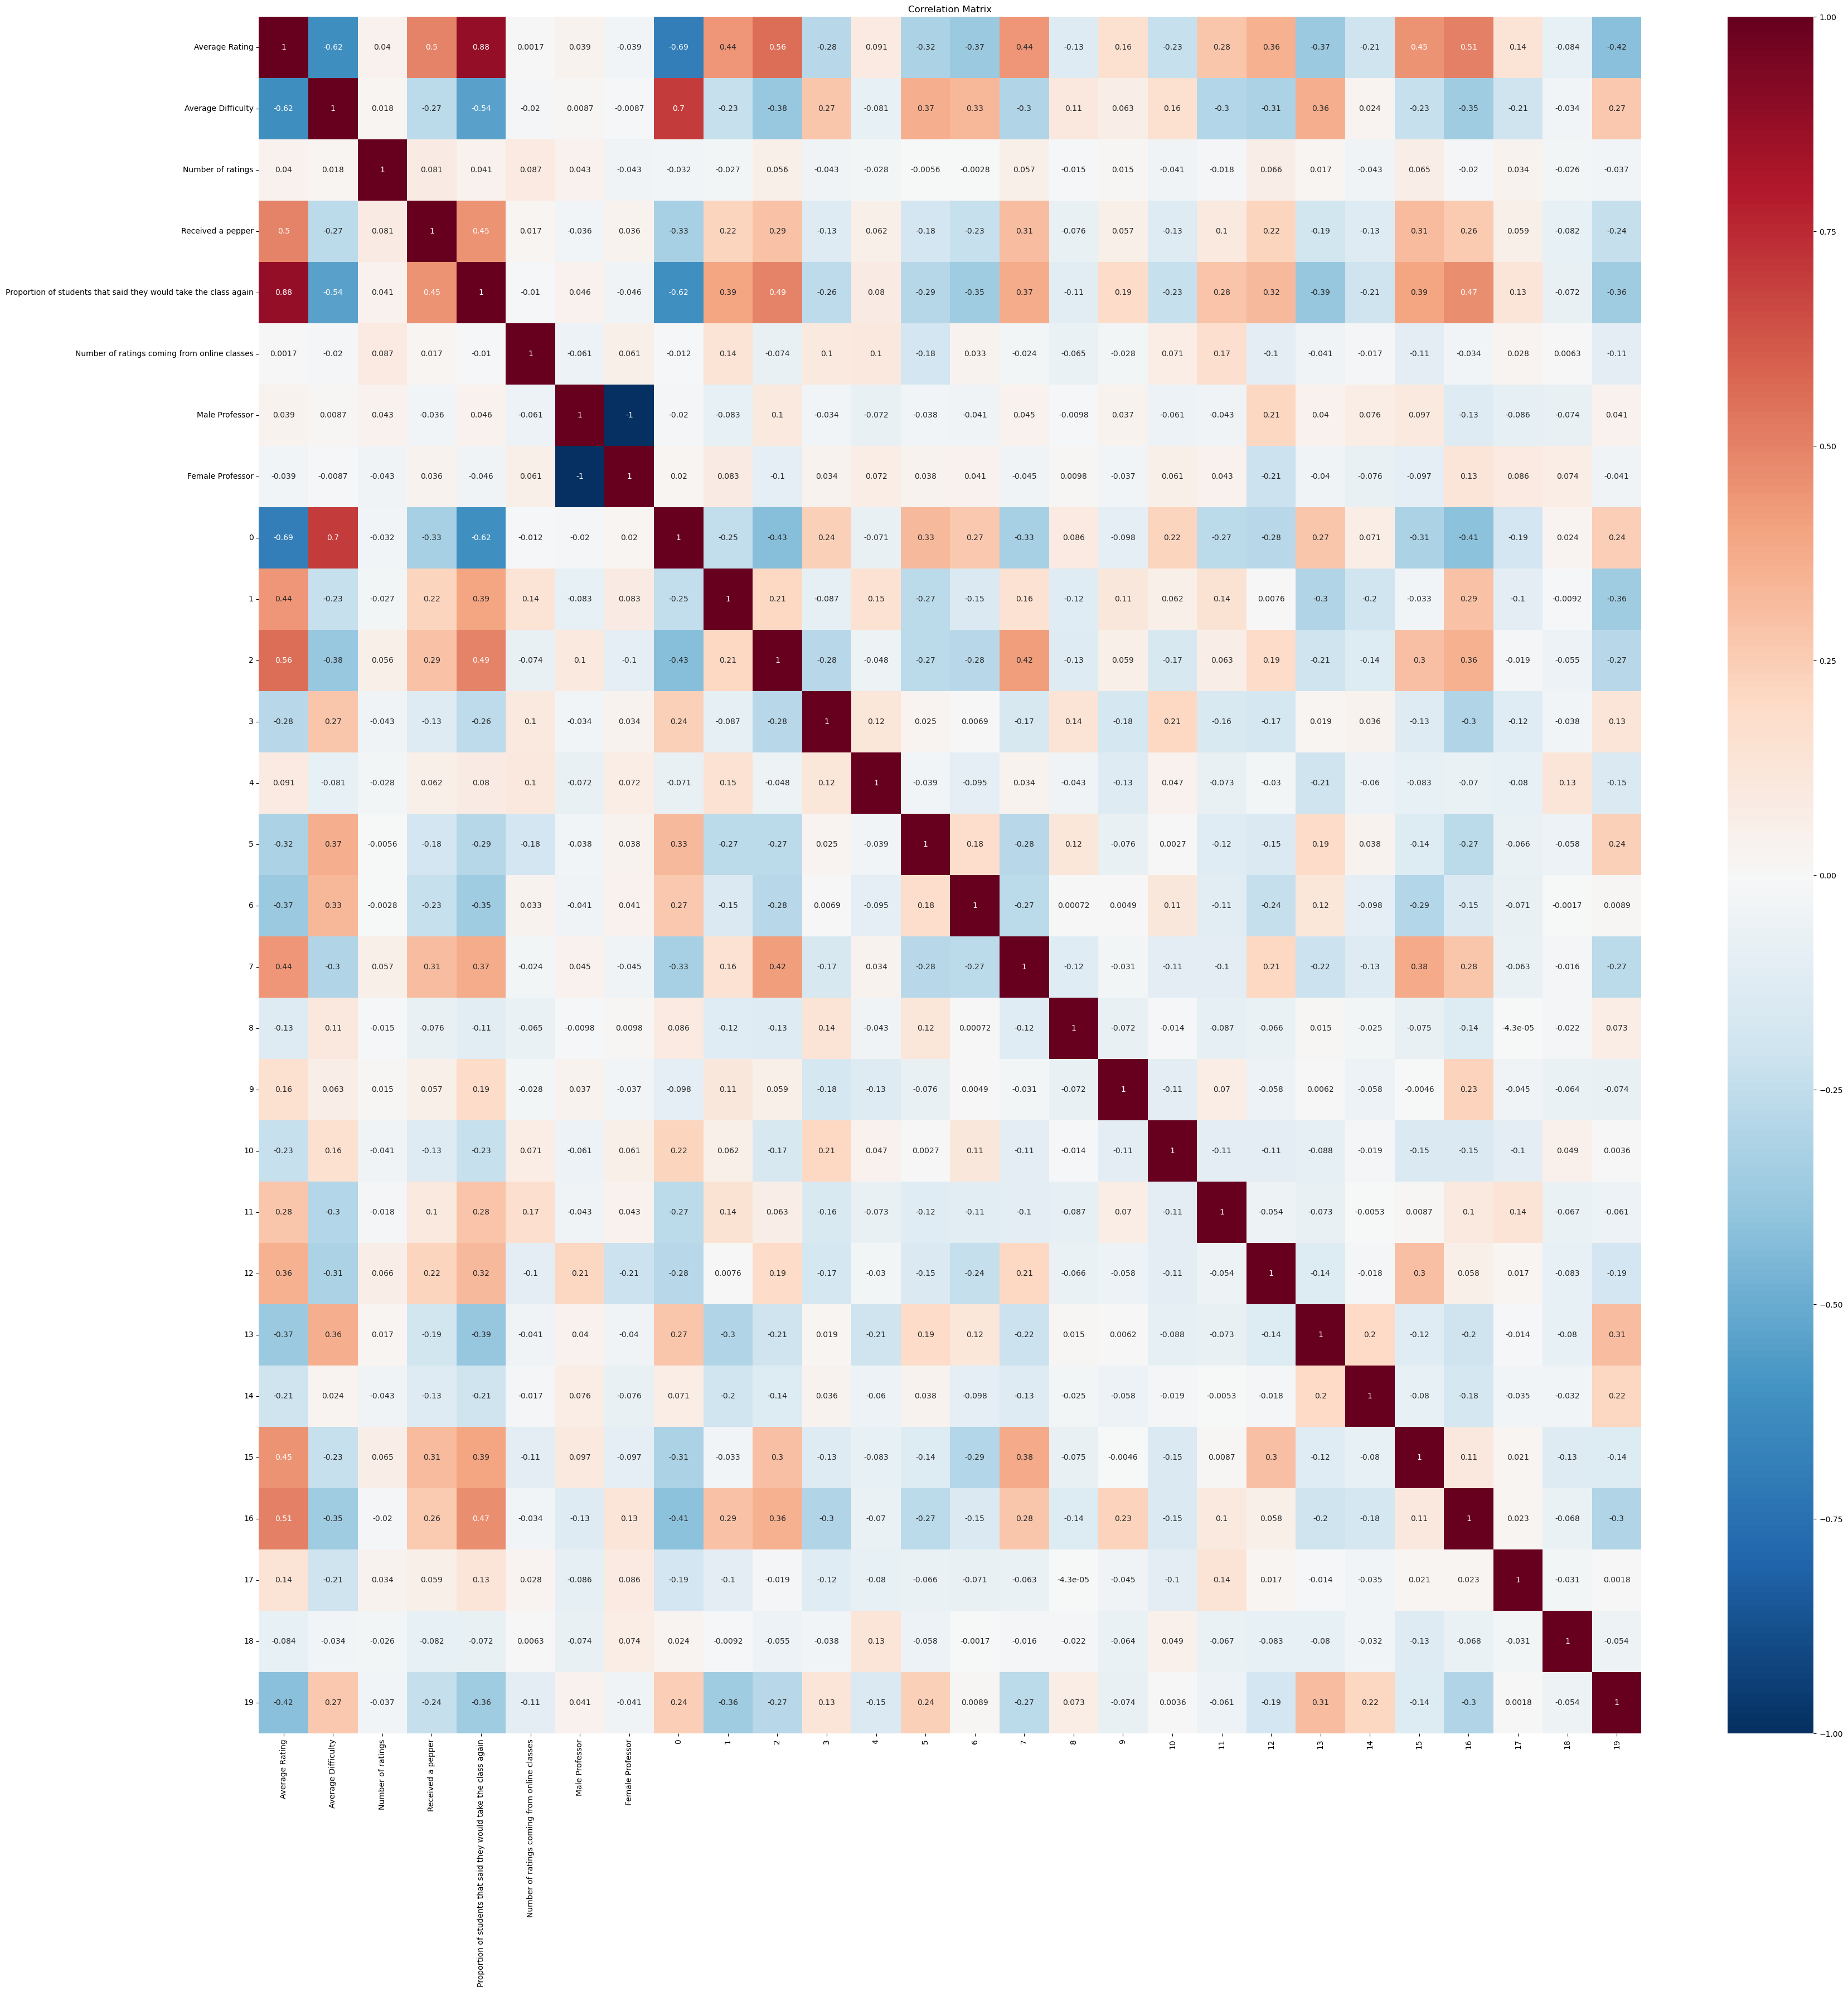

In [20]:
correlation_matrix = Q10df.corr()
plt.figure(figsize = (40,40))
sns.heatmap(correlation_matrix,cmap = "RdBu_r", annot=True)
plt.title('Correlation Matrix')
plt.show()

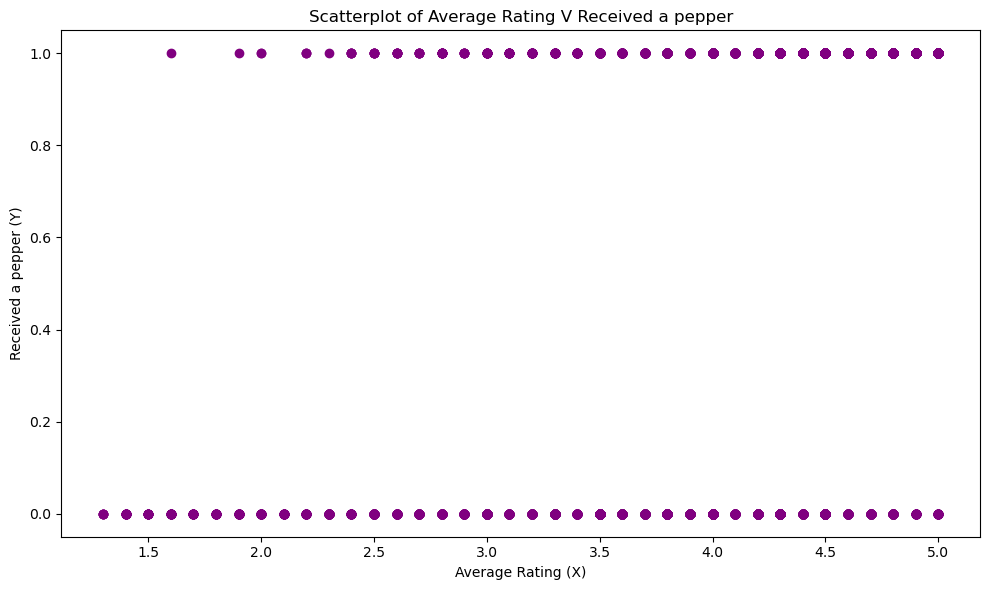

       Average Rating
88846             4.9
53948             4.9
82930             4.0
40833             3.4
21537             4.9
...               ...
19769             3.8
75621             4.5
16339             4.2
70818             4.7
67692             4.7

[4770 rows x 1 columns]
88846    0.0
53948    1.0
82930    1.0
40833    1.0
21537    1.0
        ... 
19769    1.0
75621    1.0
16339    0.0
70818    1.0
67692    0.0
Name: Received a pepper, Length: 4770, dtype: float64
      Predictions  Probabilities
1188          0.0       0.071281
1189          0.0       0.362267
1190          1.0       0.780622
1191          1.0       0.832424
1192          1.0       0.780622
Predictions      1.000000
Probabilities    0.525397
dtype: float64
Predictions      0.000000
Probabilities    0.483724
dtype: float64
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.75       607
         1.0       0.74      0.76      0.75       586

    accuracy      

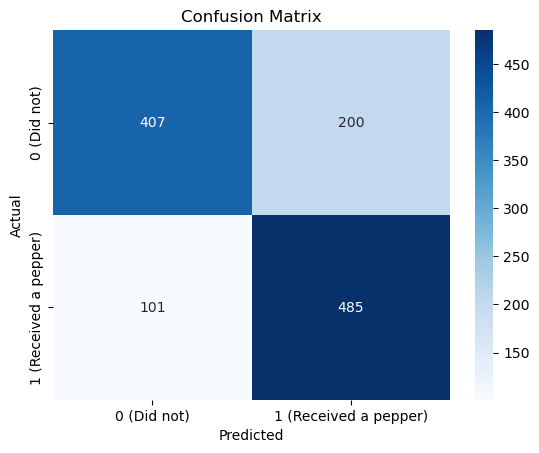

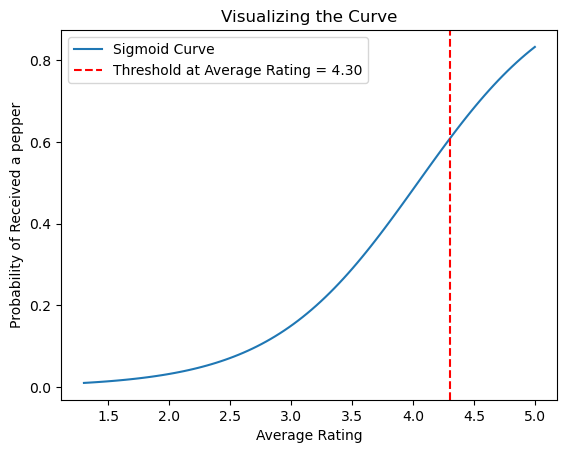

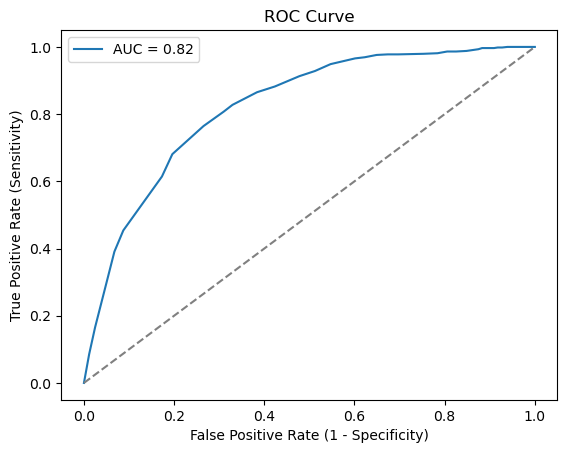

0.6071339629426625


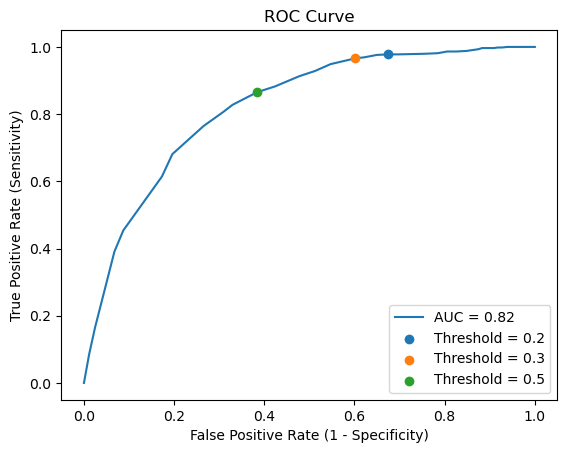

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report)
# Let's try Average Rating
averagerating = Q10df['Average Rating']
receivedapepper = Q10df['Received a pepper']
fig, ax = plt.subplots(figsize=(10,6)) # Could also do figure and plt.() later on, but subplots are a generalization

ax.scatter(x=averagerating, y=receivedapepper, c='purple') # Purple for NYU :)
ax.set_title("Scatterplot of Average Rating V Received a pepper")
ax.set_xlabel("Average Rating (X)")
ax.set_ylabel("Received a pepper (Y)")

plt.tight_layout()
plt.show()

# We definitely shouldn't draw a line through this lol
# Logistic Regression with one independent variable
X = Q10df[['Average Rating']] # Double bracket for shaping (not a worry for multiple logistic regression)
y = Q10df['Received a pepper']

# Train-test split from scikit learn
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(X_train) # see training data

print(y_train) # see target

# Fit logistic regression
log_reg_single = LogisticRegression()
log_reg_single.fit(X_train, y_train)

# Predictions
# Class
y_pred = log_reg_single.predict(X_test)

# Probabilities
y_prob = log_reg_single.predict_proba(X_test)[:, 1]

# Threshold?
# Get predictions in dataframe
results = pd.DataFrame({'Predictions': y_pred, 'Probabilities': y_prob})
print(results.tail())  # Display a few rows

print(results[results['Predictions'] == 1].min())
print(results[results['Predictions'] == 0].max())

THRESHOLD = 0.607 # Revisit later!
# THRESHOLD = optimal_threshold # from ROC curve
y_pred_new = (y_prob > THRESHOLD).astype(int)

# Calculate evaluation metrics
# Precision = TP / TP + FP
# Recall = TP / TP + FN
# F1 = 2 * P * R / (P + R) - harmonic mean, balance precision and recall
# Support - data pts in the class
# Macro metrics - average over each class
# Micro or weighted metrics - treat each sample the same

class_report = classification_report(y_test, y_pred_new) #y_pred_new
print(class_report)

# Interpret coefficients
print(log_reg_single.coef_)
# Interpret: For every increase in 1 unit of Average Rating, we expect the odds of Received a pepper relative to odds of no Received a pepper (the ratio) to increase by e^0.03
print(np.exp(log_reg_single.coef_[0])) # Slight boost for odds of Received a pepper

print(log_reg_single.intercept_)
print(np.exp(log_reg_single.intercept_)) # Not super interpretable, Average Rating wouldn't be 0. But "base" odds here.
# If Average Rating was 0, p / 1 -p or Received a pepper v no Received a pepper would be small odds

# Confusion Matrix
conf_matrix_single = confusion_matrix(y_test, y_pred) #y_pred_new
sns.heatmap(conf_matrix_single, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["0 (Did not)", "1 (Received a pepper)"], 
            yticklabels=["0 (Did not)", "1 (Received a pepper)"])

# Add title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# What do you think doc?

# Visualize the curve
# Extract coefficients
beta1 = log_reg_single.coef_[0][0]
intercept = log_reg_single.intercept_[0]

# Apply over training data
x_vals = np.linspace(X_train.min(), X_train.max(), 100)

# Logistic reg formula
y_vals = 1 / (1 + np.exp(-(beta1 * x_vals + intercept)))
plt.plot(x_vals, y_vals, label="Sigmoid Curve")

# Add threshold line
threshold = THRESHOLD
threshold_x = (np.log(threshold / (1 - threshold)) - intercept) / beta1  # Solve for x when sigmoid(x) = threshold
plt.axvline(threshold_x, color='red', linestyle='--', label=f'Threshold at Average Rating = {threshold_x:.2f}')
plt.title("Visualizing the Curve")
plt.xlabel("Average Rating")
plt.ylabel("Probability of Received a pepper")
plt.legend()
plt.show()

# ROC Curve, get AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

# Try to find optimal threshold for fitting
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
print(optimal_threshold)

# List of chosen thresholds
chosen_thresholds = [0.2, 0.3, 0.5]

# Plot ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")

# Loop over each threshold
for chosen_threshold in chosen_thresholds:
    # Find index of the threshold closest to the chosen one
    threshold_index = (np.abs(thresholds - chosen_threshold)).argmin()

    # Get the corresponding FPR and TPR for the chosen threshold
    fpr_at_threshold = fpr[threshold_index]
    tpr_at_threshold = tpr[threshold_index]

    # Plot the chosen threshold point on the ROC curve
    plt.scatter(fpr_at_threshold, tpr_at_threshold, label=f"Threshold = {chosen_threshold}", zorder=5)

# Add title, labels, and legend
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()

# Show plot
plt.show()


[[0.59459459 0.575      0.54166667 ... 0.         0.15       0.15151515]
 [0.81081081 0.575      0.82291667 ... 0.14285714 0.6875     0.06944444]
 [0.13513514 0.7        0.1875     ... 0.15238095 0.07333333 0.        ]
 ...
 [0.72972973 0.225      0.58333333 ... 0.1038961  0.1        0.2020202 ]
 [0.83783784 0.65       0.875      ... 0.32653061 0.15714286 0.07936508]
 [0.62162162 0.6        0.47916667 ... 0.11428571 0.33       0.11111111]]
(5963, 18)
[[0.97297297 0.6        0.92708333 ... 0.13445378 0.64705882 0.        ]
 [0.97297297 0.25       1.         ... 0.         0.20952381 0.05291005]
 [0.72972973 0.475      0.65625    ... 0.         0.31428571 0.        ]
 ...
 [0.78378378 0.625      0.85416667 ... 0.         0.         0.        ]
 [0.91891892 0.5        0.91666667 ... 0.30075188 0.46315789 0.        ]
 [0.91891892 0.375      1.         ... 0.1038961  0.4        0.        ]]
88846    0.0
53948    1.0
82930    1.0
40833    1.0
21537    1.0
        ... 
19769    1.0
75621    1

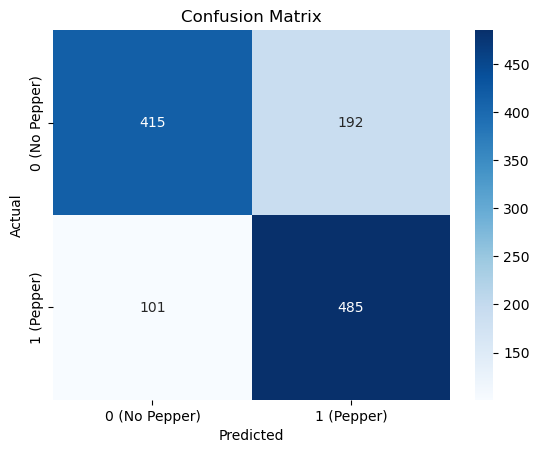

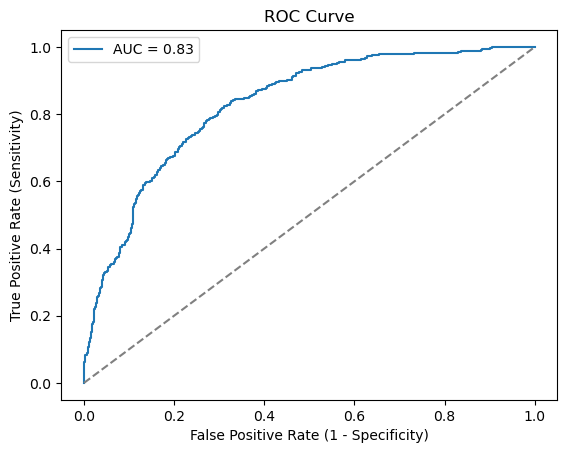

0.48851886483788465


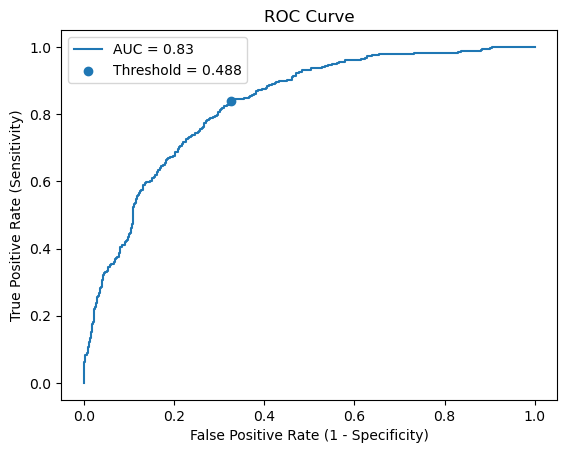

In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)
X = Q10df.drop(columns=['Received a pepper','Number of ratings','Number of ratings coming from online classes','Male Professor','Female Professor',4,8,9,17,18])  # assuming all columns except 'Average Rating' are features
X.columns =X.columns.astype(str)
# Multiple
# Apply min-max scaling to get variables on same scale
scaler = MinMaxScaler()
X = scaler.fit_transform(X) # Row-wise
print(X)
print(X.shape)

# Logistic Regression with One Explanatory Variable
y = Q10df['Received a pepper']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(X_train)
print(y_train)

# Fit logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Efficiently create and display the DataFrame
results = pd.DataFrame({'Predictions': y_pred, 'Probabilities': y_prob})
print(results.tail())  # Display a few rows

print(results[results['Predictions'] == 1].min())
print(results[results['Predictions'] == 0].max())

THRESHOLD = 0.465 # Revisit later!
# THRESHOLD = optimal_threshold
y_pred_new = (y_prob > THRESHOLD).astype(int)

class_report = classification_report(y_test, y_pred_new) #y_pred_new
print(class_report)

print(log_reg.coef_)
print(np.exp(log_reg.coef_)) # These are huge. But careful, we scaled our X variables (between 0 and 1). Still interpretable over fractional units.

print(log_reg.intercept_)
print(np.exp(log_reg.intercept_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred) #y_pred_new
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["0 (No Pepper)", "1 (Pepper)"], 
            yticklabels=["0 (No Pepper)", "1 (Pepper)"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
print(optimal_threshold)

# List of chosen thresholds
chosen_thresholds = [0.488]

# Plot ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")

# Loop over each threshold
for chosen_threshold in chosen_thresholds:
    # Find index of the threshold closest to the chosen one
    threshold_index = (np.abs(thresholds - chosen_threshold)).argmin()

    # Get the corresponding FPR and TPR for the chosen threshold
    fpr_at_threshold = fpr[threshold_index]
    tpr_at_threshold = tpr[threshold_index]

    # Plot the chosen threshold point on the ROC curve
    plt.scatter(fpr_at_threshold, tpr_at_threshold, label=f"Threshold = {chosen_threshold}", zorder=5)

# Add title, labels, and legend
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()

# Show plot
plt.show()

Classification Report:

              precision    recall  f1-score   support

         0.0       0.83      0.66      0.73       607
         1.0       0.71      0.85      0.77       586

    accuracy                           0.76      1193
   macro avg       0.77      0.76      0.75      1193
weighted avg       0.77      0.76      0.75      1193



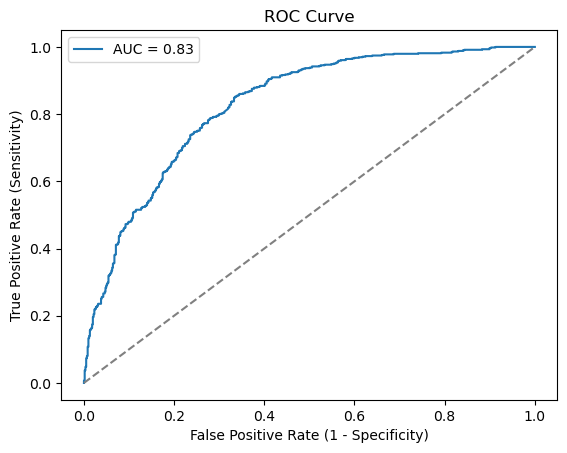

In [31]:
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Get predictions and classification report
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Coefficients and intercept for hyperplane
w = svm_model.coef_[0]
b = svm_model.intercept_[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()